In this part, we focus on batch-correction for multi-sample Human DLPFC

In [42]:
import scanpy as sc
import numpy as np
import sctm
import squidpy as sq
import pandas as pd
import seaborn as sns
import anndata as ad
import scib_metrics
from scib_metrics.benchmark import Benchmarker

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
adata = sc.read_h5ad("../../../../STAMP/Visium_DLPFC/adata.h5ad")

In [33]:
adata
# The data  already have spatia lneighbors built with default scanpy 

AnnData object with n_obs × n_vars = 47681 × 4000
    obs: 'in_tissue', 'array_row', 'array_col', 'library_id', 'layer', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable_rank', 'highly_variable'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'beta', 'neighbors', 'spatial', 'spatial_neighbors', 'topic_prop', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_stamp', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
# In this case, we use the SGC, since we want the embeddings to be smooth

model = sctm.stamp.STAMP(
    adata,
    n_topics = 10,
    # layer="count",
    categorical_covariate_keys=["library_id"],
    mode="sgc",
    gene_likelihood="nb")

# We uses a weighted sampler so that each batch is sampled equally. However since we downsampled, it doesnt actually matters much 
model.train(learning_rate = 0.01)

In [35]:
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
for i in topic_prop.columns:
    adata.obs[i] =  topic_prop[i]

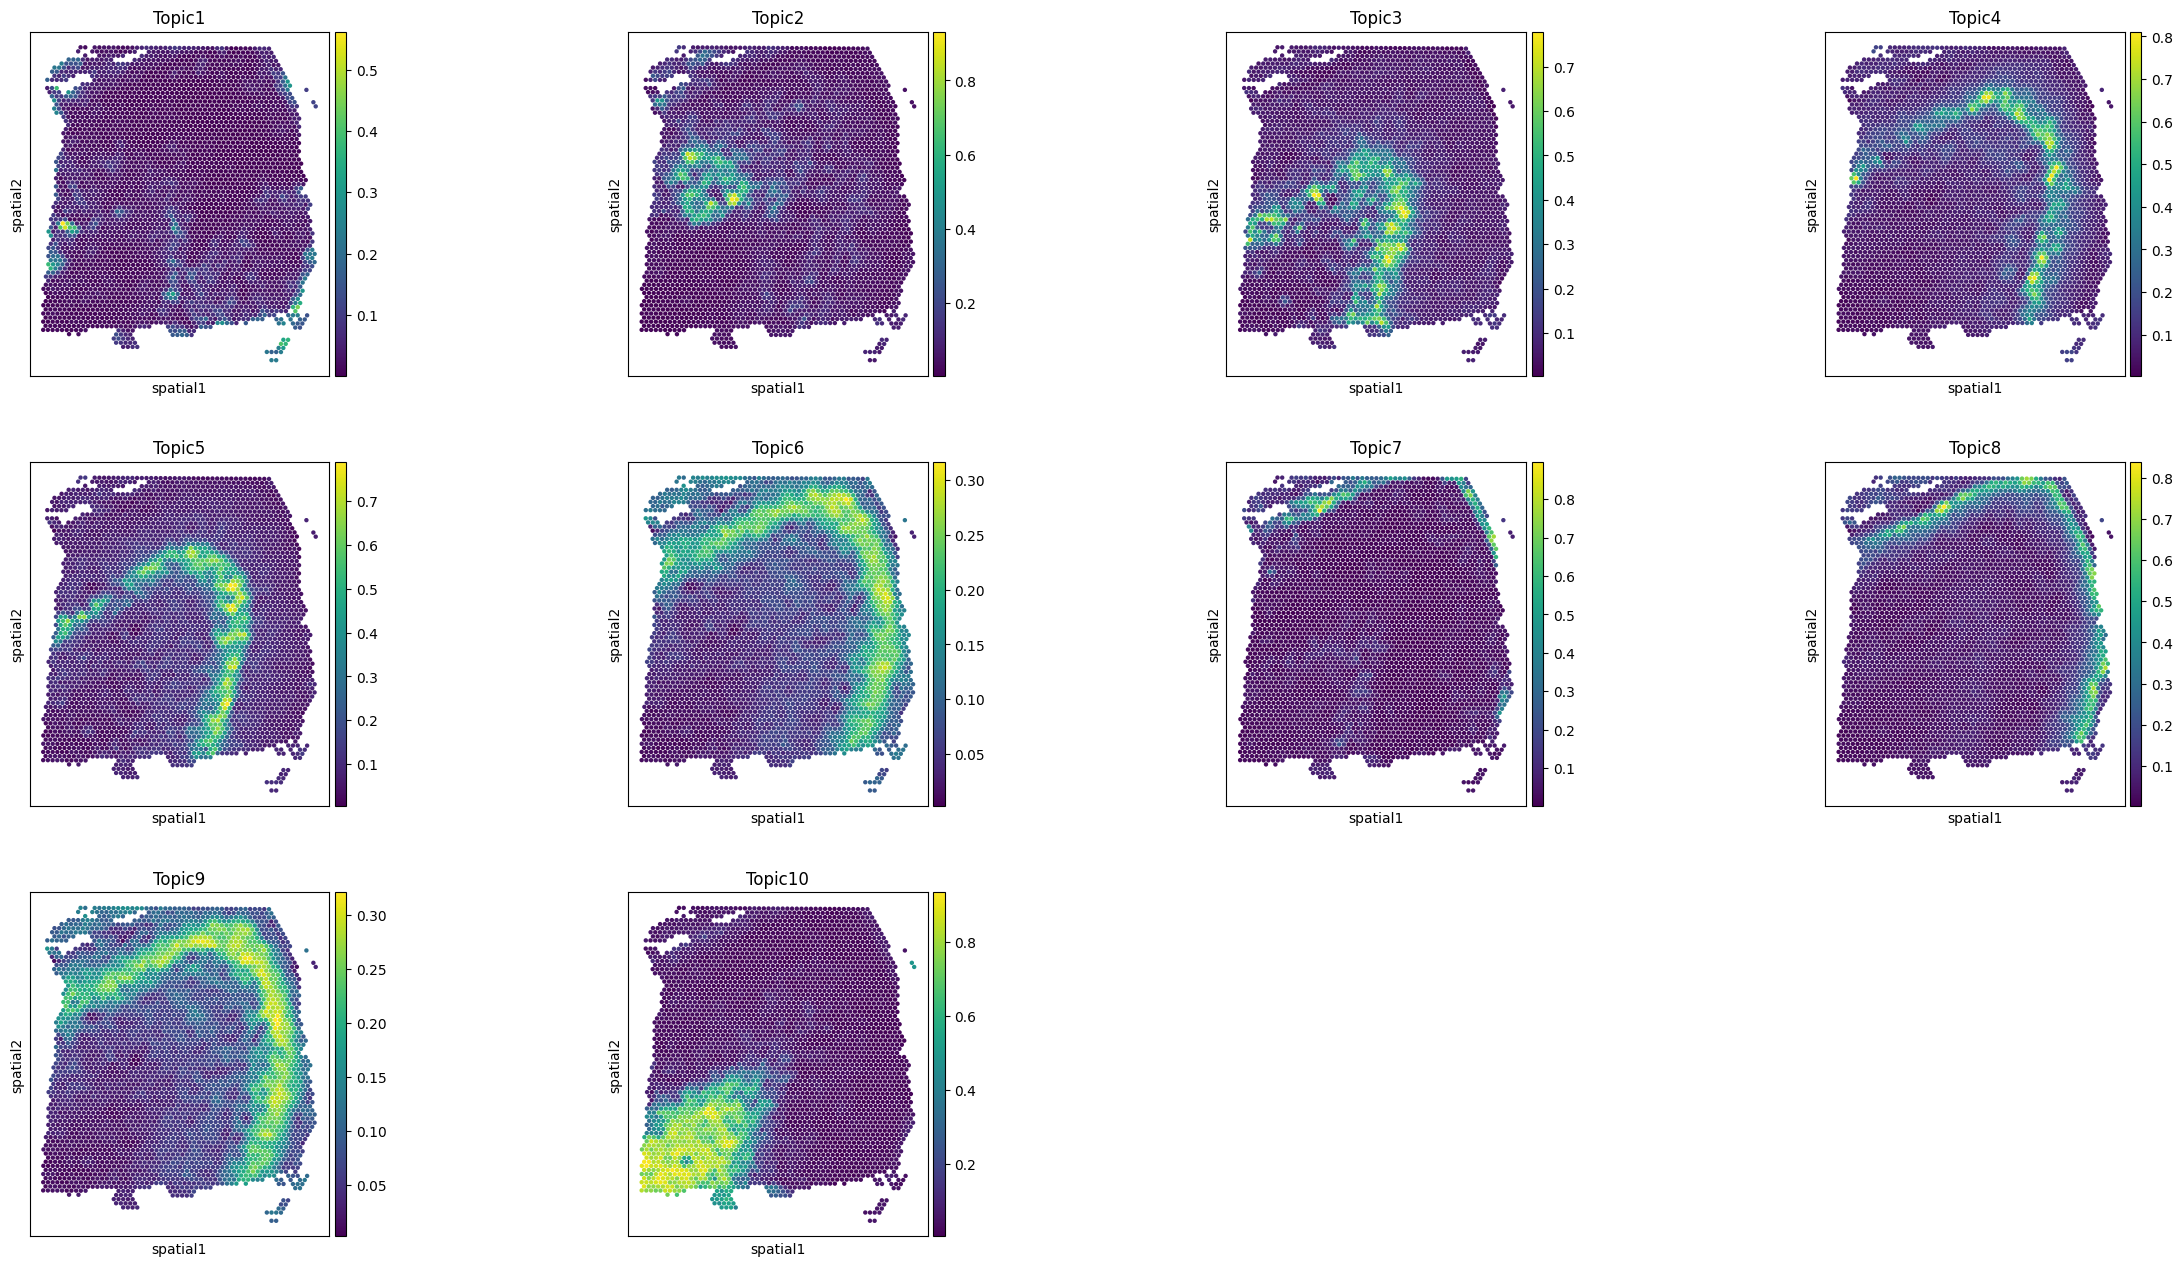

In [40]:
adata1 = adata[adata.obs.library_id == "151673"]
sctm.pl.spatial(adata1, color = topic_prop.columns, size = 40)

In [43]:
adata.obsm["X_stamp"] = topic_prop.values

In [47]:
adata.obs['library_id'] = adata.obs['library_id'].astype('category')
adata.obs['layer'] = adata.obs['layer'].astype('category')

In [57]:
# Remove the NA ones so we can benchmark
adata = adata[~adata.obs.layer.isna()]

In [68]:
adata.obsm["X_stamp"] = np.random.standard_normal((47329, 10)) * 1e-8 + adata.obsm["X_stamp"]

In [69]:
bm = Benchmarker(
    adata,
    batch_key="library_id",
    label_key="layer",
    embedding_obsm_keys=["X_stamp", "X_pca"],
    n_jobs=6,
)
bm.benchmark()

Embeddings: 100%|██████████| 2/2 [05:25<00:00, 162.83s/it]


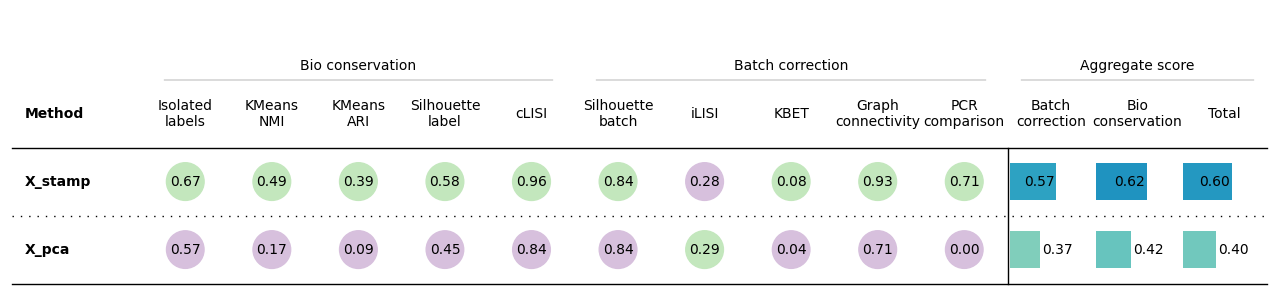

In [70]:
bm.plot_results_table(min_max_scale=False)